## Setup

In [0]:
# The code in this cell is only necessary when using Google Colab and storing 
# the data on Google Drive. If you don't use that combination, ignore it.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from os import listdir
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from tensorflow.keras.utils import to_categorical

print(tf.__version__)

1.14.0


In [0]:
# Replace these paths with the paths to the directories with your training 
# and testing data respectively.
# Each of the two directories should have three subdirectories named 'matrix',
# 'notype' and 'unpacking' with each subdirectory containing the images of the
# respective class.
train_data_dir = '/content/drive/My Drive/data3/train/'
test_data_dir = '/content/drive/My Drive/data3/validation/'

# Replace this path with the path to the directory you want to save the files 
# produced by this notebook in.
notebook_path = '/content/drive/My Drive/Colab Notebooks/testset/BA_CNN_Simple_Testset_Evaluation/'

batch_size = 10
train_samples = 300
validation_samples = 30
k_folds = 5
hyperparams_description = 'try2_100epochs_pixel244x244_noES_k5'
img_height, img_width = 244, 244

## Load images

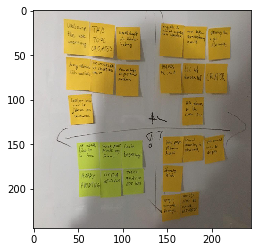

(244, 244, 3)
[1 0 0]
ndarray
ndarray


In [0]:
# loading datasets directly into memory beforehand - about 20 times faster when training
samples_x = []
samples_y = []
test_x = []
test_y = []

def add_class_from_dir(class_dir, label, data_x, data_y):
  class_samples = listdir(class_dir)
  for image in class_samples:
    img = load_img(path=class_dir + image, target_size=(img_height, img_width))
    data_x.append(img_to_array(img))
    data_y.append(label)

add_class_from_dir(class_dir=train_data_dir + 'matrix/', label=[1,0,0], data_x=samples_x, data_y=samples_y)
add_class_from_dir(class_dir=train_data_dir + 'unpacking/', label=[0,1,0], data_x=samples_x, data_y=samples_y)
add_class_from_dir(class_dir=train_data_dir + 'notype/', label=[0,0,1], data_x=samples_x, data_y=samples_y)

add_class_from_dir(class_dir=test_data_dir + 'matrix/', label=[1,0,0], data_x=test_x, data_y=test_y)
add_class_from_dir(class_dir=test_data_dir + 'unpacking/', label=[0,1,0], data_x=test_x, data_y=test_y)
add_class_from_dir(class_dir=test_data_dir + 'notype/', label=[0,0,1], data_x=test_x, data_y=test_y)

samples_x = np.array(samples_x)
test_x = np.array(test_x)
samples_y = np.array(samples_y)
test_y = np.array(test_y)

plt.figure()
plt.imshow(samples_x[0]/(255))
plt.show()
print(samples_x[0].shape)
print(samples_y[0])
print(type(samples_x).__name__)
print(type(test_x).__name__)

In [0]:
len(samples_x)

300

## Train and evaluate model

In [0]:
def create_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape=(img_height, img_width, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2))) # 3D feature maps (height, width, features)

  model.add(Flatten())  # 3D feature maps to 1D feature vectors
  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(3))
  model.add(Activation('softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['categorical_accuracy'])
  return model

In [0]:
# data augmentation
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_generator = train_datagen.flow(
    x=samples_x,
    y=samples_y,
    batch_size=batch_size)

test_generator = test_datagen.flow(
    x=test_x,
    y=test_y,
    batch_size=batch_size,
    shuffle=False)

In [0]:
model = create_model()

model.fit_generator(
        train_generator,
        epochs=100,
        validation_data=test_generator)
result = model.evaluate(test_generator)
model.save_weights(filepath=notebook_path + hyperparams_description + f'_split_testset_final_weights.h5')

Epoch 1/100
30/30 [==============================] - 3s 116ms/step - loss: 1.1630 - acc: 0.3233 - val_loss: 1.1041 - val_acc: 0.3333
Epoch 2/100
30/30 [==============================] - 3s 105ms/step - loss: 1.1612 - acc: 0.3433 - val_loss: 1.0974 - val_acc: 0.3333
Epoch 3/100
30/30 [==============================] - 3s 107ms/step - loss: 1.0978 - acc: 0.3000 - val_loss: 1.1160 - val_acc: 0.3667
Epoch 4/100
30/30 [==============================] - 3s 110ms/step - loss: 1.1085 - acc: 0.3900 - val_loss: 1.0954 - val_acc: 0.4667
Epoch 5/100
30/30 [==============================] - 3s 107ms/step - loss: 1.1062 - acc: 0.4267 - val_loss: 1.1009 - val_acc: 0.4333
Epoch 6/100
30/30 [==============================] - 3s 109ms/step - loss: 1.0992 - acc: 0.4333 - val_loss: 1.0891 - val_acc: 0.3000
Epoch 7/100
30/30 [==============================] - 3s 108ms/step - loss: 1.0875 - acc: 0.4233 - val_loss: 1.2596 - val_acc: 0.3333
Epoch 8/100
30/30 [==============================] - 3s 109ms/step - 

## Reload model in order to print confusion matrix

In [0]:
model = create_model()
model.load_weights(filepath=notebook_path + hyperparams_description + f'_split_testset_final_weights.h5')
pred_y = model.predict_classes(test_generator)
print(classification_report(test_y, to_categorical(pred_y)))
model.evaluate(test_generator)
test = list(map(lambda x: np.argmax(x), test_y))
sess = tf.Session()
with sess.as_default():
  print(tf.math.confusion_matrix(test, pred_y).eval())
print(pred_y)
print(test)

              precision    recall  f1-score   support

           0       0.33      0.10      0.15        10
           1       0.45      0.90      0.60        10
           2       0.86      0.60      0.71        10

   micro avg       0.53      0.53      0.53        30
   macro avg       0.55      0.53      0.49        30
weighted avg       0.55      0.53      0.49        30
 samples avg       0.53      0.53      0.53        30

3/3 [==============================] - 1s 211ms/step - loss: 1.1473 - categorical_accuracy: 0.5333
[[1 8 1]
 [1 9 0]
 [1 3 6]]
[1 1 0 1 1 1 1 1 1 2 1 1 1 1 1 0 1 1 1 1 2 2 2 2 2 2 1 1 0 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
